In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# add seed_everything function for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # if using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # deterministic behavior (can slow things down slightly)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [3]:
def setup_gpu_acceleration():
    """Set up GPU acceleration based on available hardware."""
    import platform
    import os
    
    # Initialize variables
    use_gpu = False
    gpu_type = None
    tree_method = "hist"  # Default CPU method for tree-based models
    
    # Check for CUDA (NVIDIA GPUs)
    try:
        import torch
        if torch.cuda.is_available():
            use_gpu = True
            gpu_type = "CUDA"
            tree_method = "gpu_hist"
            n_gpus = torch.cuda.device_count()
            gpu_name = torch.cuda.get_device_name(0)
            print(f"CUDA GPU detected: {gpu_name} ({n_gpus} device(s))")
    except ImportError:
        pass
        
    # If CUDA not found, check for Mac MPS (Apple Silicon/Metal)
    if not use_gpu and platform.system() == "Darwin":  # Darwin = macOS
        try:
            # Check if Mac has Apple Silicon
            is_apple_silicon = platform.processor() == 'arm' or 'Apple M' in os.popen('sysctl -n machdep.cpu.brand_string').read()
            
            if is_apple_silicon:
                use_gpu = True
                gpu_type = "MPS"
                tree_method = "gpu_hist"  # For tree-based models that support Metal
                print("Apple Silicon GPU detected")
                
                # Set Metal-specific environment variables if needed
                os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
        except:
            pass
    
    if not use_gpu:
        print("⚠️ No compatible GPU detected. Using CPU only.")
    
    return {
        "use_gpu": use_gpu,
        "gpu_type": gpu_type,
        "tree_method": tree_method,
        "device": "cuda" if gpu_type == "CUDA" else "mps" if gpu_type == "MPS" else "cpu"
    }

# Run the setup
gpu_config = setup_gpu_acceleration()

Apple Silicon GPU detected


In [4]:
# load the processed data
data_audi = pd.read_csv('processed_audi.csv')

data_audi.head()

# Define target and features
target = "price"
features = [col for col in data_audi.columns if col != target]

In [5]:
# # label encoding for 'model'
# label_encoder = LabelEncoder()
# data_audi['model'] = label_encoder.fit_transform(data_audi['model'])
# data_audi['transmission'] = label_encoder.fit_transform(data_audi['transmission'])
# data_audi['fuelType'] = label_encoder.fit_transform(data_audi['fuelType'])

# Baseline Models

In [6]:
N_ESTIMATORS = 100

## XGBoost

In [7]:
# Split dataset
X = data_audi[features]
y = data_audi[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# fit data into XGBoost model
start_train = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.3, max_depth=6)
xgb_model.fit(X_train, y_train)
xgb_train_time = time.time() - start_train

# make predictions
start_pred = time.time()
xgb_y_pred = xgb_model.predict(X_test)
xgb_pred_time = time.time() - start_pred

xgb_avg_pred_time_ms = (xgb_pred_time / len(X_test)) * 1000

# evaluate the model
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_rmspe = np.sqrt(np.mean(np.square((y_test - xgb_y_pred) / y_test)))

print(f"RMSPE: {xgb_rmspe:.4f}, MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")
print(f"Training time: {xgb_train_time:.2f}s")
print(f"Avg prediction time per sample: {xgb_avg_pred_time_ms:.4f} ms")

RMSPE: 0.0106, MAE: 0.0722, RMSE: 0.1018, R²: 0.9548
Training time: 0.04s
Avg prediction time per sample: 0.0012 ms


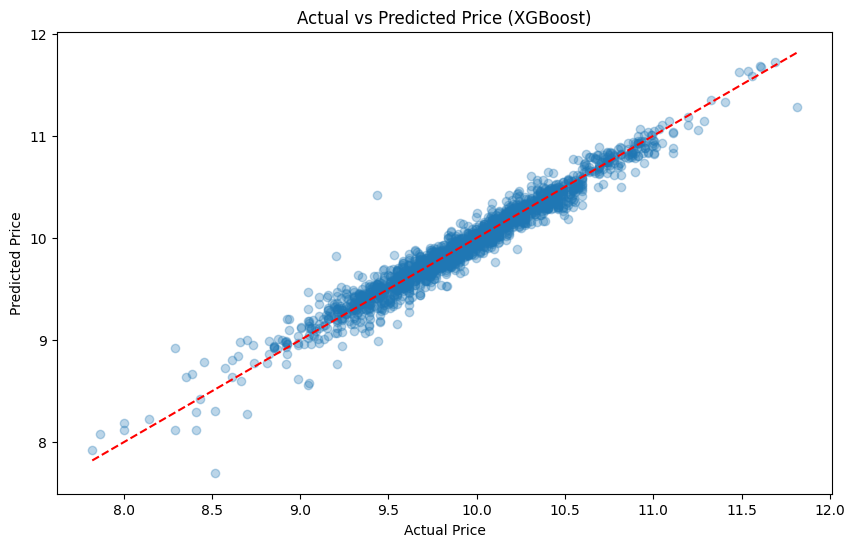

In [9]:
# plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (XGBoost)")
plt.show()

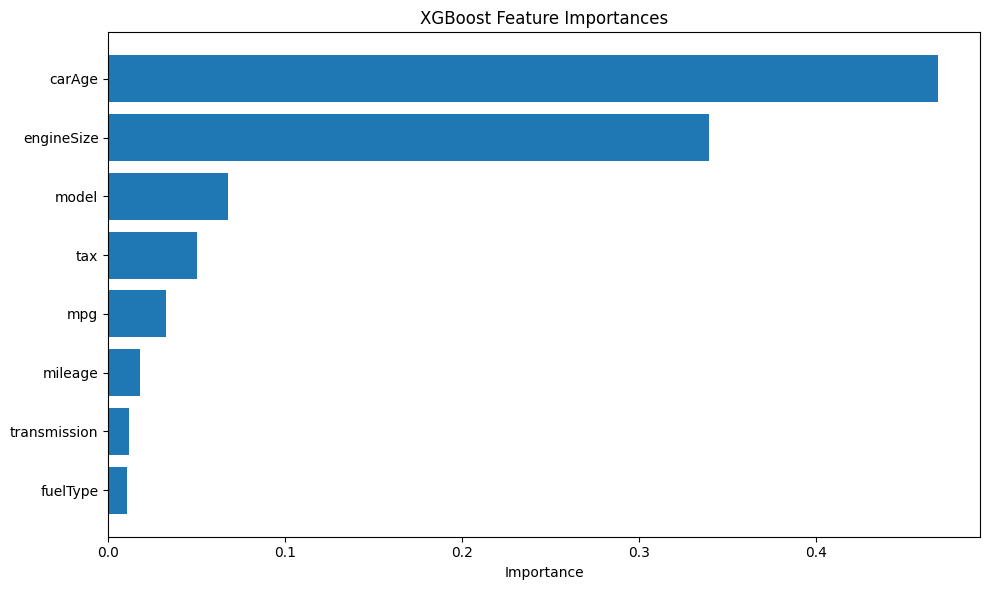

In [10]:
# Get importances and sort
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]  # Sort descending

# Get sorted feature names
sorted_features = [features[i] for i in xgb_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], xgb_importances[xgb_indices][::-1])  # Reverse for top-to-bottom
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Random Forest

In [11]:
# Split dataset
X = data_audi[features]
y = data_audi[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# fit data into random forest model
start_train = time.time()
rf_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_time = time.time() - start_train

# make predictions
start_pred = time.time()
rf_y_pred = rf_model.predict(X_test)
rf_pred_time = time.time() - start_pred

rf_avg_pred_time_ms = (rf_pred_time / len(X_test)) * 1000

# evaluate the model
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
rf_r2 = r2_score(y_test, rf_y_pred)
rf_rmspe = np.sqrt(np.mean(np.square((y_test - rf_y_pred) / y_test)))

print(f"RMSPE: {rf_rmspe:.4f}, MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"Training time: {rf_train_time:.2f}s")
print(f"Avg prediction time per sample: {rf_avg_pred_time_ms:.4f} ms")

RMSPE: 0.0107, MAE: 0.0756, RMSE: 0.1034, R²: 0.9534
Training time: 1.05s
Avg prediction time per sample: 0.0158 ms


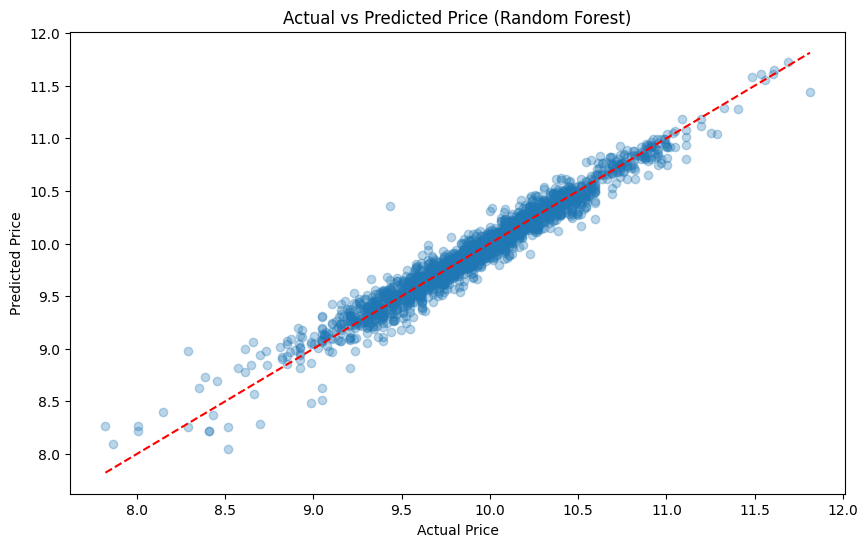

In [13]:
# plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Random Forest)")
plt.show()

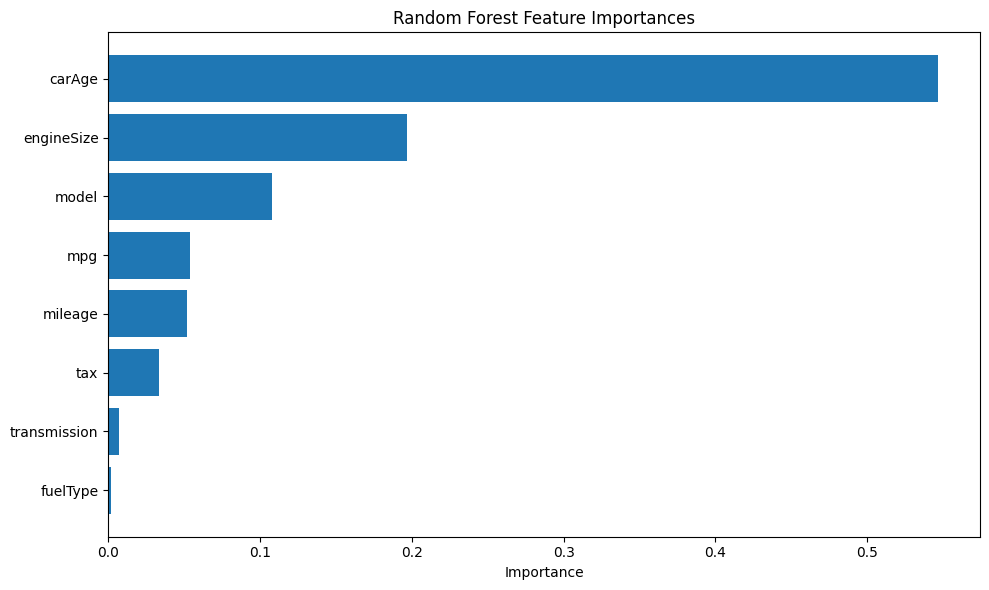

In [14]:
# Get importances and sort
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]  # Sort descending

# Get sorted feature names
sorted_features = [features[i] for i in rf_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], rf_importances[rf_indices][::-1])  # Reverse for top-to-bottom
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Deep Learning Models

In [15]:
# Common parameters for all models
EPOCHS = 500  # A middle ground between your current settings
BATCH_SIZE = 256  # Good balance between speed and memory
PATIENCE = 15  # Early stopping patience

# Set the device to GPU if available
device = torch.device(gpu_config["device"])

categorical_cols = ['model', 'transmission', 'fuelType']

## TabNet

In [16]:
# Split dataset
X = data_audi[features]
y = data_audi[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cast features to float32 (TabNet requires this)
X_train_float32 = X_train.values.astype(np.float32)
X_test_float32 = X_test.values.astype(np.float32)
y_train_float32 = y_train.values.astype(np.float32)
y_test_float32 = y_test.values.astype(np.float32)

# TabNet-specific categorical info
cat_idxs = [X.columns.get_loc(col) for col in categorical_cols]
cat_dims = [int(X_train[col].max()) + 1 for col in categorical_cols]

In [17]:
start_time = time.time()

# Define the model
tabnet_model = TabNetRegressor(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    n_d=8,
    n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    device_name=device
)

# Train
tabnet_model.fit(
    X_train=X_train_float32, y_train=y_train_float32.reshape(-1, 1),
    eval_set=[(X_test_float32, y_test_float32.reshape(-1, 1))],
    eval_metric=['rmse', 'mae'],
    eval_name=['test'],
    max_epochs=EPOCHS, 
    patience=PATIENCE, 
    batch_size=BATCH_SIZE, 
    virtual_batch_size=128,
    num_workers=0
)

tabnet_train_time = time.time() - start_time
tabnet_early_stop_epoch = tabnet_model.best_epoch + 1

/opt/homebrew/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : mps
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.55126| test_rmse: 3.61080002784729| test_mae: 3.1167500019073486|  0:00:01s
epoch 1  | loss: 0.35692 | test_rmse: 1.6035200357437134| test_mae: 1.4425100088119507|  0:00:03s
epoch 2  | loss: 0.13954 | test_rmse: 1.0650299787521362| test_mae: 0.9285299777984619|  0:00:04s
epoch 3  | loss: 0.06839 | test_rmse: 0.4072900116443634| test_mae: 0.3229900002479553|  0:00:05s
epoch 4  | loss: 0.07072 | test_rmse: 0.354449987411499| test_mae: 0.2859100103378296|  0:00:07s
epoch 5  | loss: 0.06176 | test_rmse: 0.48291000723838806| test_mae: 0.374210000038147|  0:00:08s
epoch 6  | loss: 0.07354 | test_rmse: 0.398250013589859| test_mae: 0.30660000443458557|  0:00:09s
epoch 7  | loss: 0.05089 | test_rmse: 0.2836500108242035| test_mae: 0.20221999287605286|  0:00:11s
epoch 8  | loss: 0.05175 | test_rmse: 0.24398000538349152| test_mae: 0.1990099996328354|  0:00:12s
epoch 9  | loss: 0.04158 | test_rmse: 0.17465999722480774| test_mae: 0.1375100016593933|  0:00:13s
epoch 10 | loss: 0.0

/opt/homebrew/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [18]:
# make predictions
start_pred = time.time()
tabnet_y_pred = tabnet_model.predict(X_test_float32)
tabnet_pred_time = time.time() - start_pred

tabnet_avg_pred_time_ms = (tabnet_pred_time / len(X_test_float32)) * 1000

# evaluate the model
tabnet_mae = mean_absolute_error(y_test_float32, tabnet_y_pred)
tabnet_rmse = np.sqrt(mean_squared_error(y_test_float32, tabnet_y_pred))
tabnet_r2 = r2_score(y_test_float32, tabnet_y_pred)
tabnet_rmspe = np.sqrt(np.mean(np.square((y_test_float32 - tabnet_y_pred) / y_test_float32)))

print(f"RMSPE: {tabnet_rmspe:.4f}, MAE: {tabnet_mae:.4f}, RMSE: {tabnet_rmse:.4f}, R²: {tabnet_r2:.4f}")
print(f"TabNet training time: {tabnet_train_time:.2f}s")
print(f"TabNet early stopping epoch: {tabnet_early_stop_epoch}")
print(f"Avg prediction time per sample: {tabnet_avg_pred_time_ms:.4f} ms")


RMSPE: 0.0685, MAE: 0.0900, RMSE: 0.1179, R²: 0.9394
TabNet training time: 84.68s
TabNet early stopping epoch: 47
Avg prediction time per sample: 0.0652 ms


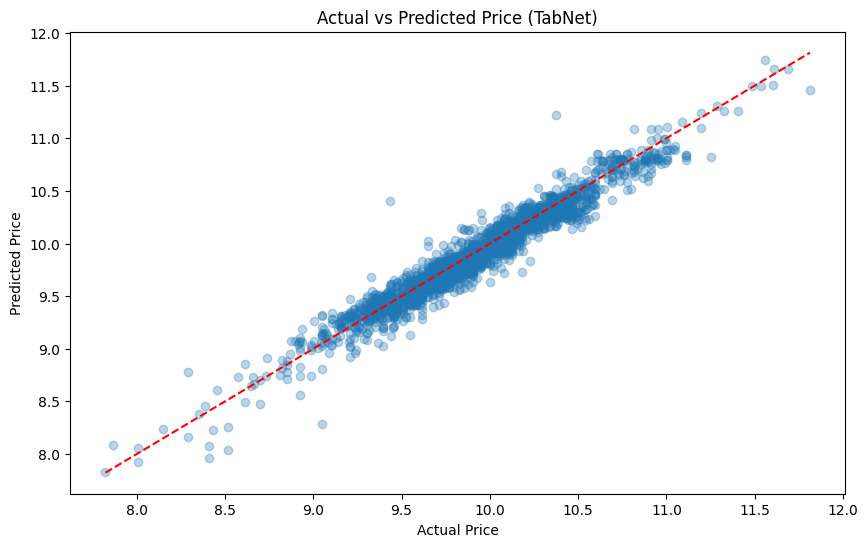

In [19]:
# plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, tabnet_y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (TabNet)")
plt.show()

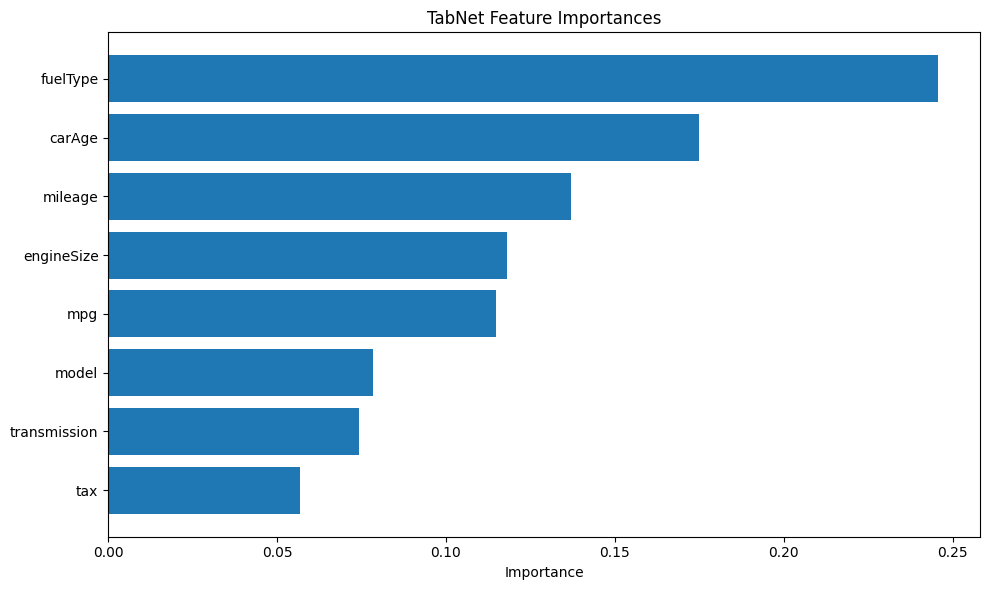

In [20]:
# Get importances and sort
tabnet_importances = tabnet_model.feature_importances_
tabnet_indices = np.argsort(tabnet_importances)[::-1]  # Sort descending

# Get sorted feature names
sorted_features = [features[i] for i in tabnet_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], tabnet_importances[tabnet_indices][::-1])  # Reverse for top-to-bottom
plt.title("TabNet Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## NODE (Neural Oblivious Decision Ensemble)

In [21]:
# Data preparation
class AudiDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor([self.y[idx]])
    

node_data = data_audi.copy()
num_cols = [col for col in node_data.columns if col not in categorical_cols + ['price']]

for col in categorical_cols:
    node_data[col] = node_data[col].astype('category').cat.codes

features = num_cols + categorical_cols
X = node_data[features].values
y = np.log1p(node_data['price'].values)

scaler = StandardScaler()
X[:, :len(num_cols)] = scaler.fit_transform(X[:, :len(num_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = AudiDataset(X_train, y_train)
test_dataset = AudiDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [22]:
# NODE model components
class ObliviousLayer(nn.Module):
    def __init__(self, in_features, num_trees=16, tree_depth=3):
        super().__init__()
        self.num_trees = num_trees
        self.tree_depth = tree_depth
        self.feature_selectors = nn.Parameter(torch.randn(num_trees, tree_depth, in_features))
        self.thresholds = nn.Parameter(torch.zeros(num_trees, tree_depth))
        self.leaf_responses = nn.Parameter(torch.zeros(num_trees, 2 ** tree_depth))

    def forward(self, x):
        logits = torch.einsum('bi,tdi->btd', x, self.feature_selectors)
        decisions = torch.sigmoid(logits - self.thresholds.unsqueeze(0))
        paths = torch.ones(x.size(0), self.num_trees, 1, device=x.device)
        for d in range(self.tree_depth):
            decision = decisions[:, :, d].unsqueeze(-1)
            paths = torch.cat([paths * decision, paths * (1 - decision)], dim=-1)
        leaf_weights = F.softmax(paths, dim=-1)
        output = torch.einsum('btl,tl->bt', leaf_weights, self.leaf_responses)
        return output.mean(dim=1, keepdim=True)

class NODERegressor(nn.Module):
    def __init__(self, in_features, num_trees=16, tree_depth=3):
        super().__init__()
        self.tree_layer = ObliviousLayer(in_features, num_trees, tree_depth)
    def forward(self, x):
        return self.tree_layer(x)

In [23]:
# Initialize model
node_model = NODERegressor(X.shape[1]).to(device)
optimizer = torch.optim.Adam(node_model.parameters(), lr=0.02)
criterion = nn.MSELoss()

# === Track training time ===
start_train = time.time()

best_rmse = float('inf')
early_stop_counter = 0
node_early_stop_epoch = EPOCHS  # fallback if no early stop

for epoch in range(EPOCHS):
    node_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = node_model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    node_model.eval()
    with torch.no_grad():
        all_preds, all_targets = [], []
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = node_model(xb)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

        node_y_predict = np.vstack(all_preds).flatten()
        node_y_true = np.vstack(all_targets).flatten()

        node_rmse = np.sqrt(mean_squared_error(node_y_true, node_y_predict))
        node_mae = mean_absolute_error(node_y_true, node_y_predict)
        node_r2 = r2_score(node_y_true, node_y_predict)
        node_rmspe = np.sqrt(np.mean(np.square((node_y_true - node_y_predict) / node_y_true)))

        print(f"Epoch {epoch+1}: RMSE={node_rmse:.2f}, MAE={node_mae:.2f}, R²={node_r2:.4f}")

        if node_rmse < best_rmse:
            best_rmse = node_rmse
            best_mae = node_mae
            early_stop_counter = 0
            node_early_stop_epoch = epoch + 1
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"Early stopping occurred at epoch {epoch+1} (best at epoch {node_early_stop_epoch})")
                break

# === Training time ===
node_train_time = time.time() - start_train

# === Prediction time per sample ===
start_pred = time.time()
with torch.no_grad():
    preds_all = []
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds_all.append(node_model(xb))
end_pred = time.time()
node_avg_pred_time_ms = (end_pred - start_pred) / len(test_loader.dataset) * 1000

# === Final metrics ===
print("\nNODE Final Test Evaluation:")
print(f"RMSPE: {node_rmspe:.4f}, MAE: {node_mae:.4f}, RMSE: {node_rmse:.4f}, R²: {node_r2:.4f}")
print(f"Training Time: {node_train_time:.2f}s")
print(f"Early Stopping Epoch: {node_early_stop_epoch}")
print(f"Prediction Time per Sample: {node_avg_pred_time_ms:.4f} ms")

Epoch 1: RMSE=1.75, MAE=1.75, R²=-1574.5568
Epoch 2: RMSE=1.18, MAE=1.18, R²=-719.0615
Epoch 3: RMSE=0.74, MAE=0.74, R²=-279.5193
Epoch 4: RMSE=0.42, MAE=0.42, R²=-91.8108
Epoch 5: RMSE=0.22, MAE=0.22, R²=-24.9333
Epoch 6: RMSE=0.11, MAE=0.11, R²=-5.6265
Epoch 7: RMSE=0.06, MAE=0.05, R²=-1.0497
Epoch 8: RMSE=0.05, MAE=0.04, R²=-0.1537
Epoch 9: RMSE=0.04, MAE=0.03, R²=0.0528
Epoch 10: RMSE=0.04, MAE=0.03, R²=0.2351
Epoch 11: RMSE=0.03, MAE=0.02, R²=0.4306
Epoch 12: RMSE=0.03, MAE=0.02, R²=0.5666
Epoch 13: RMSE=0.03, MAE=0.02, R²=0.6482
Epoch 14: RMSE=0.02, MAE=0.02, R²=0.7006
Epoch 15: RMSE=0.02, MAE=0.02, R²=0.7322
Epoch 16: RMSE=0.02, MAE=0.01, R²=0.7514
Epoch 17: RMSE=0.02, MAE=0.01, R²=0.7648
Epoch 18: RMSE=0.02, MAE=0.01, R²=0.7751
Epoch 19: RMSE=0.02, MAE=0.01, R²=0.7877
Epoch 20: RMSE=0.02, MAE=0.01, R²=0.8000
Epoch 21: RMSE=0.02, MAE=0.01, R²=0.8094
Epoch 22: RMSE=0.02, MAE=0.01, R²=0.8170
Epoch 23: RMSE=0.02, MAE=0.01, R²=0.8231
Epoch 24: RMSE=0.02, MAE=0.01, R²=0.8273
Epoch 25

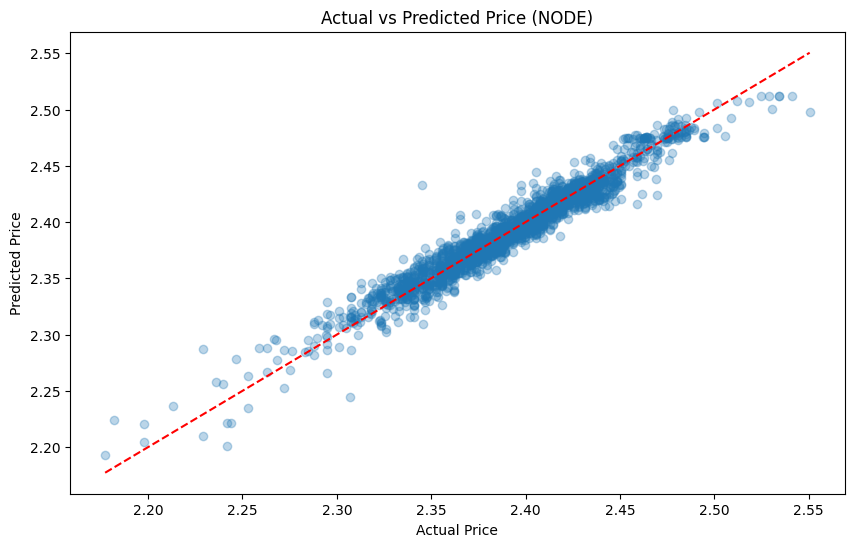

In [24]:
# plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(node_y_true, node_y_predict, alpha=0.3)
plt.plot([min(node_y_true), max(node_y_true)],
         [min(node_y_true), max(node_y_true)], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (NODE)")
plt.show()

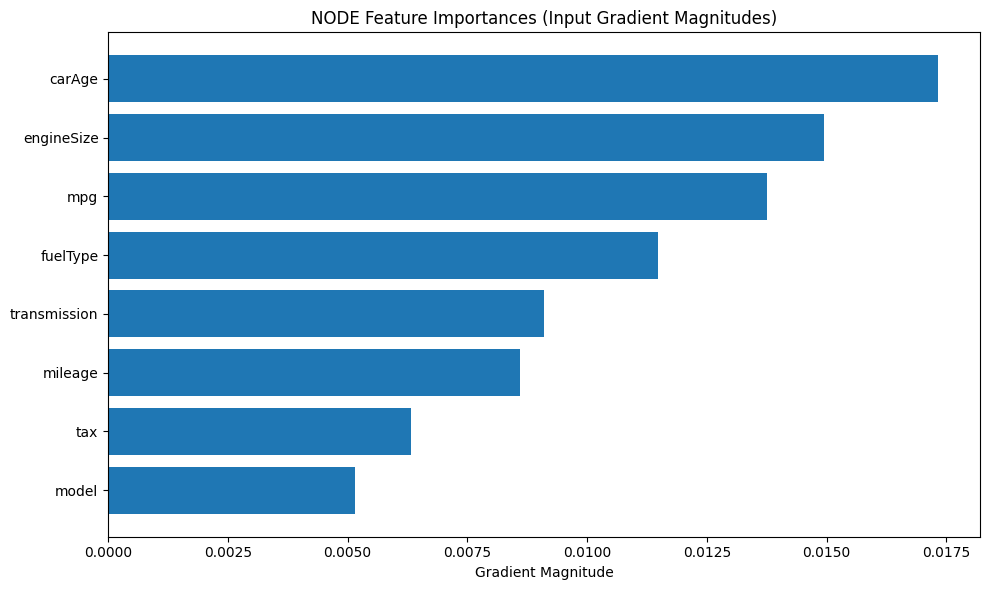

In [25]:
# feature importance via gradients
node_model.eval()
X_test_tensor = torch.FloatTensor(X_test).to(device).requires_grad_(True)
preds = node_model(X_test_tensor)
preds.sum().backward()
node_importances = X_test_tensor.grad.abs().mean(dim=0).cpu().numpy()
node_indices = np.argsort(node_importances)[::-1]
sorted_features = [features[i] for i in node_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], node_importances[node_indices][::-1])  # Top-down
plt.title("NODE Feature Importances (Input Gradient Magnitudes)")
plt.xlabel("Gradient Magnitude")
plt.tight_layout()
plt.show()

## FT Transformer

In [26]:
# Data preparation
class TabularDataset(Dataset):
    def __init__(self, numerical_features, categorical_features, targets=None):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.targets = targets

    def __len__(self):
        return len(next(iter(self.categorical_features.values())))

    def __getitem__(self, idx):
        numerical = self.numerical_features[idx] if self.numerical_features is not None else None
        categorical = {name: values[idx] for name, values in self.categorical_features.items()}
        if self.targets is not None:
            return numerical, categorical, torch.tensor(self.targets[idx], dtype=torch.float32).unsqueeze(0)
        return numerical, categorical
    
ft_data = data_audi.copy()
numerical_cols = [col for col in ft_data.columns if col not in categorical_cols + ['price']]

cat_maps = {col: {v: i for i, v in enumerate(ft_data[col].unique())} for col in categorical_cols}
for col, mapping in cat_maps.items():
    ft_data[col] = ft_data[col].map(mapping)

categorical_features = {col: ft_data[col].values for col in categorical_cols}
categorical_cardinality = {col: len(cat_maps[col]) for col in categorical_cols}

scaler = StandardScaler()
ft_data[numerical_cols] = scaler.fit_transform(ft_data[numerical_cols])

X_num = ft_data[numerical_cols].values.astype(np.float32)
y = ft_data['price'].values.astype(np.float32)
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)
cat_train = {col: values[train_idx] for col, values in categorical_features.items()}
cat_test = {col: values[test_idx] for col, values in categorical_features.items()}

train_dataset = TabularDataset(torch.FloatTensor(X_num_train), {k: torch.LongTensor(v) for k, v in cat_train.items()}, y_train)
test_dataset = TabularDataset(torch.FloatTensor(X_num_test), {k: torch.LongTensor(v) for k, v in cat_test.items()}, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [27]:
# FTTransformer model components
class CategoricalFeatureTokenizer(nn.Module):
    def __init__(self, cardinality: int, embed_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(cardinality, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embedding(x.long()).unsqueeze(1)

class NumericalFeatureTokenizer(nn.Module):
    def __init__(self, in_dim: int, embed_dim: int):
        super().__init__()
        self.projection = nn.Linear(in_dim, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection(x.float()).unsqueeze(1)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads
        self.num_heads = num_heads
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v):
        batch_size = q.size(0)
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.depth ** 0.5)
        weights = F.softmax(scores, dim=-1)
        output = torch.matmul(weights, v)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.depth)
        return self.dense(output)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = self.dropout(self.mha(x, x, x))
        x = self.norm1(x + attn_output)
        ffn_output = self.dropout(self.ffn(x))
        return self.norm2(x + ffn_output)

class FTTransformer(nn.Module):
    def __init__(self, num_numerical_features, categorical_features_info, d_token=32, num_transformer_blocks=2,
                 num_attention_heads=2, d_ffn_factor=4/3, attention_dropout=0.1, ffn_dropout=0.1, num_classes=1):
        super().__init__()
        self.d_token = d_token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))

        self.numerical_tokenizer = NumericalFeatureTokenizer(num_numerical_features, d_token) if num_numerical_features > 0 else None
        self.categorical_tokenizers = nn.ModuleDict({
            name: CategoricalFeatureTokenizer(cardinality, d_token)
            for name, cardinality in categorical_features_info.items()
        })

        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model=d_token, num_heads=num_attention_heads,
                                    d_ff=int(d_token * d_ffn_factor), dropout=attention_dropout)
            for _ in range(num_transformer_blocks)
        ])

        self.norm = nn.LayerNorm(d_token)
        self.head = nn.Sequential(
            nn.Linear(d_token, 1),
            nn.ReLU()
        )

    def forward(self, numerical_features=None, categorical_features=None):
        B = numerical_features.size(0) if numerical_features is not None else next(iter(categorical_features.values())).size(0)
        tokens = [self.cls_token.expand(B, -1, -1)]

        if numerical_features is not None:
            tokens.append(self.numerical_tokenizer(numerical_features))

        if categorical_features is not None:
            for name, values in categorical_features.items():
                tokens.append(self.categorical_tokenizers[name](values))

        x = torch.cat(tokens, dim=1)
        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x[:, 0])
        return self.head(x)

In [28]:
# Initialize model
ft_model = FTTransformer(
    num_numerical_features=X_num_train.shape[1],
    categorical_features_info=categorical_cardinality
).to(device)

optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.02)
criterion = nn.MSELoss()

best_rmse = float('inf')
early_stop_counter = 0
ft_early_stop_epoch = EPOCHS  # fallback value

# === Start training timer ===
start_train = time.time()

for epoch in range(EPOCHS):
    ft_model.train()
    for x_num, x_cat, yb in train_loader:
        x_num = x_num.to(device)
        x_cat = {k: v.to(device) for k, v in x_cat.items()}
        yb = yb.to(device)
        preds = ft_model(x_num, x_cat)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    ft_model.eval()
    with torch.no_grad():
        all_preds, all_targets = [], []
        for x_num, x_cat, yb in test_loader:
            x_num = x_num.to(device)
            x_cat = {k: v.to(device) for k, v in x_cat.items()}
            yb = yb.to(device)
            out = ft_model(x_num, x_cat)
            all_preds.append(out.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

        ft_y_predict = np.vstack(all_preds).flatten()
        ft_y_true = np.vstack(all_targets).flatten()
        ft_rmse = np.sqrt(mean_squared_error(ft_y_true, ft_y_predict))
        ft_mae = mean_absolute_error(ft_y_true, ft_y_predict)
        ft_r2 = r2_score(ft_y_true, ft_y_predict)
        ft_rmspe = np.sqrt(np.mean(np.square((ft_y_true - ft_y_predict) / ft_y_true)))

        print(f"Epoch {epoch+1}: RMSE={ft_rmse:.4f}, MAE={ft_mae:.4f}, R2={ft_r2:.4f}")

        if ft_rmse < best_rmse:
            best_rmse = ft_rmse
            best_mae = ft_mae
            early_stop_counter = 0
            ft_early_stop_epoch = epoch + 1
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"Early stopping occurred at epoch {epoch+1} (best at epoch {ft_early_stop_epoch})")
                break

# === End training timer ===
ft_train_time = time.time() - start_train

# === Prediction time per sample ===
start_pred = time.time()
with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num = x_num.to(device)
        x_cat = {k: v.to(device) for k, v in x_cat.items()}
        _ = ft_model(x_num, x_cat)
end_pred = time.time()
ft_avg_pred_time_ms = (end_pred - start_pred) / len(test_loader.dataset) * 1000

# === Final Output ===
print("\nFT-Transformer Final Test Evaluation:")
print(f"RMSPE: {ft_rmspe:.4f}, MAE: {ft_mae:.4f}, RMSE: {ft_rmse:.4f}, R²: {ft_r2:.4f}")
print(f"Training Time: {ft_train_time:.2f}s")
print(f"Early Stopping Epoch: {ft_early_stop_epoch}")
print(f"Prediction Time per Sample: {ft_avg_pred_time_ms:.4f} ms")

Epoch 1: RMSE=0.4801, MAE=0.3713, R2=-0.0039
Epoch 2: RMSE=0.5213, MAE=0.4108, R2=-0.1835
Epoch 3: RMSE=0.4931, MAE=0.3888, R2=-0.0593
Epoch 4: RMSE=0.2983, MAE=0.2254, R2=0.6124
Epoch 5: RMSE=0.2305, MAE=0.1829, R2=0.7687
Epoch 6: RMSE=0.2314, MAE=0.1885, R2=0.7668
Epoch 7: RMSE=0.2160, MAE=0.1795, R2=0.7968
Epoch 8: RMSE=0.1804, MAE=0.1426, R2=0.8583
Epoch 9: RMSE=0.1879, MAE=0.1518, R2=0.8462
Epoch 10: RMSE=0.1744, MAE=0.1390, R2=0.8676
Epoch 11: RMSE=0.1851, MAE=0.1519, R2=0.8508
Epoch 12: RMSE=0.1969, MAE=0.1635, R2=0.8312
Epoch 13: RMSE=0.1661, MAE=0.1296, R2=0.8798
Epoch 14: RMSE=0.1617, MAE=0.1260, R2=0.8861
Epoch 15: RMSE=0.1699, MAE=0.1279, R2=0.8743
Epoch 16: RMSE=0.1632, MAE=0.1278, R2=0.8841
Epoch 17: RMSE=0.1361, MAE=0.1056, R2=0.9194
Epoch 18: RMSE=0.1554, MAE=0.1217, R2=0.8948
Epoch 19: RMSE=0.1588, MAE=0.1260, R2=0.8902
Epoch 20: RMSE=0.1528, MAE=0.1208, R2=0.8983
Epoch 21: RMSE=0.1444, MAE=0.1109, R2=0.9091
Epoch 22: RMSE=0.1388, MAE=0.1095, R2=0.9161
Epoch 23: RMSE=0

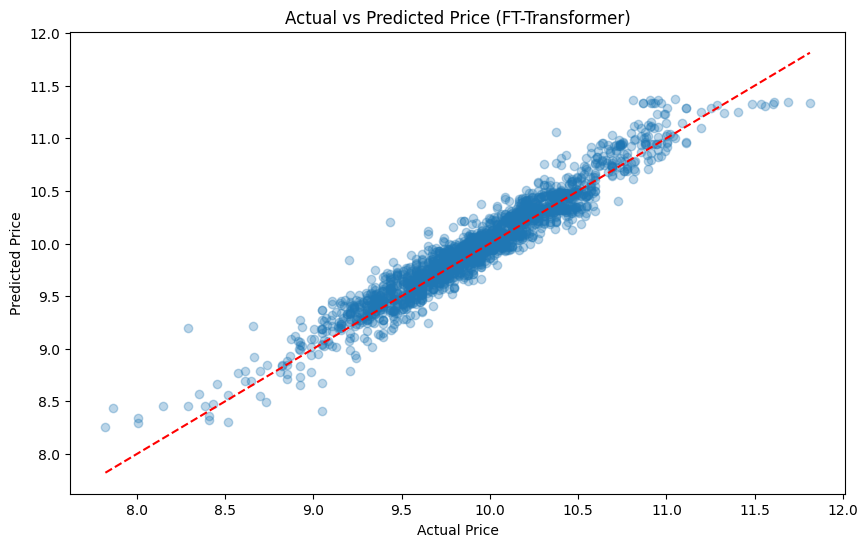

In [29]:
# plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(ft_y_true, ft_y_predict, alpha=0.3)
plt.plot([min(ft_y_true), max(ft_y_true)],
         [min(ft_y_true), max(ft_y_true)], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (FT-Transformer)")
plt.show()

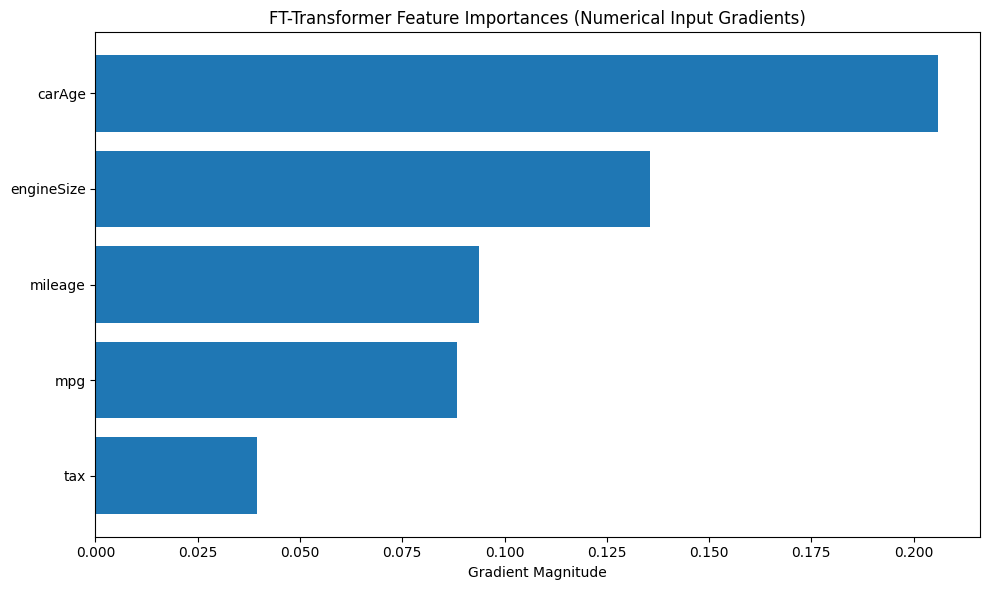

In [30]:
# feature importance
ft_model.eval()
X_test_num_tensor = torch.FloatTensor(X_num_test).to(device).requires_grad_(True)
X_test_cat_tensor = {k: torch.LongTensor(v).to(device) for k, v in cat_test.items()}
out = ft_model(X_test_num_tensor, X_test_cat_tensor)
out.sum().backward()
ft_importances = X_test_num_tensor.grad.abs().mean(dim=0).cpu().numpy()
ft_indices = np.argsort(ft_importances)[::-1]
sorted_num_features = [col for col in numerical_cols]
sorted_features = [sorted_num_features[i] for i in ft_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], ft_importances[ft_indices][::-1])
plt.title("FT-Transformer Feature Importances (Numerical Input Gradients)")
plt.xlabel("Gradient Magnitude")
plt.tight_layout()
plt.show()

In [31]:
# === 1. Summary Table ===
model_names = ['XGBoost', 'Random Forest', 'TabNet', 'NODE', 'FT-Transformer']
mae = [round(x, 4) for x in [xgb_mae, rf_mae, tabnet_mae, node_mae, ft_mae]]
rmse = [round(x, 4) for x in [xgb_rmse, rf_rmse, tabnet_rmse, node_rmse, ft_rmse]]
rmspe = [round(x, 4) for x in [xgb_rmspe, rf_rmspe, tabnet_rmspe, node_rmspe, ft_rmspe]]
r2 = [round(x, 4) for x in [xgb_r2, rf_r2, tabnet_r2, node_r2, ft_r2]]
train_time = [round(x, 4) for x in [xgb_train_time, rf_train_time, tabnet_train_time, node_train_time, ft_train_time]]
early_epoch = [N_ESTIMATORS, N_ESTIMATORS, tabnet_early_stop_epoch, node_early_stop_epoch, ft_early_stop_epoch]
pred_time_ms = [round(x, 4) for x in [xgb_avg_pred_time_ms, rf_avg_pred_time_ms, tabnet_avg_pred_time_ms, node_avg_pred_time_ms, ft_avg_pred_time_ms]]

df_summary = pd.DataFrame({
    'Model': model_names,
    'RMSPE': rmspe,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2,
    'Training Time (s)': train_time,
    'Early Stopping Epoch': early_epoch,
    'Prediction Time (ms/sample)': pred_time_ms
})

df_summary

,Model,RMSPE,MAE,RMSE,R²,Training Time (s),Early Stopping Epoch,Prediction Time (ms/sample)
0,XGBoost,0.0106,0.0722,0.1018,0.9548,0.0407,100,0.0012
1,Random Forest,0.0107,0.0756,0.1034,0.9534,1.0525,100,0.0158
2,TabNet,0.0685,0.0900,0.1179,0.9394,84.6807,47,0.0652
3,NODE,0.0045,0.0081,0.0107,0.9404,39.2995,256,0.0073
4,FT-Transformer,0.0140,0.1047,0.1372,0.9180,18.0074,17,0.0161


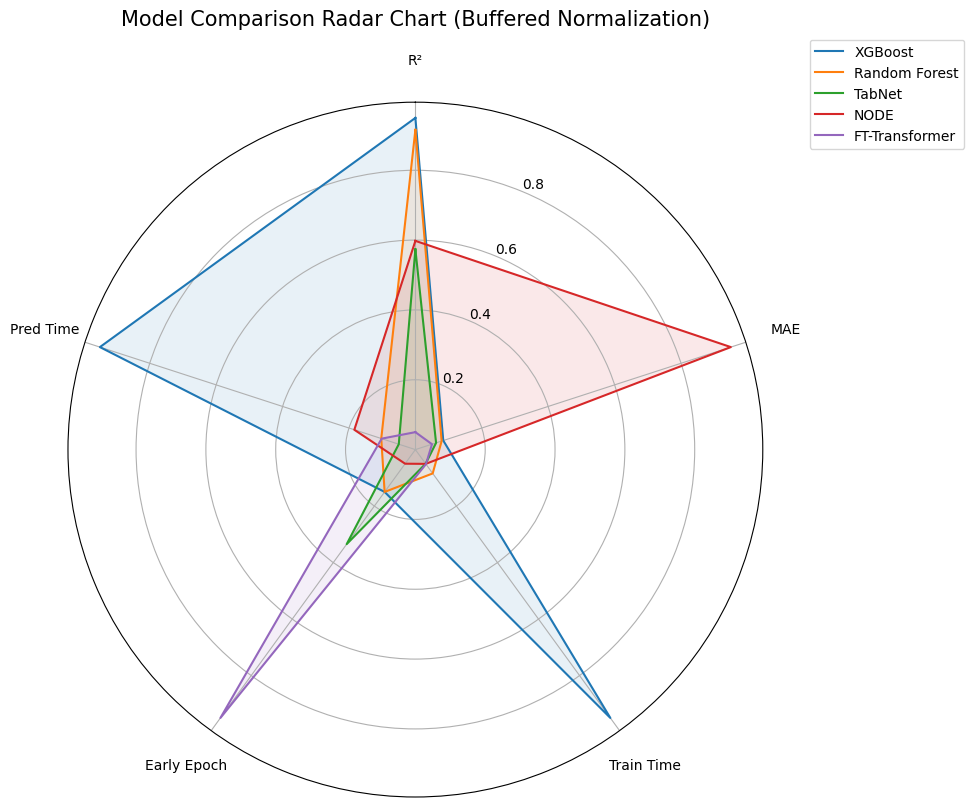

In [32]:
# === 2. Radar Chart ===
# Apply min-max normalization with slight buffer to avoid exact 0 and 1
def normalize_with_buffer(series, lower=0.05, upper=0.95):
    min_val, max_val = series.min(), series.max()
    return lower + (series - min_val) * (upper - lower) / (max_val - min_val)

# Copy again
normalized = df_summary.copy()

# Invert values where smaller is better
normalized['MAE'] = 1 / normalized['MAE']
normalized['Training Time (s)'] = 1 / normalized['Training Time (s)']
normalized['Early Stopping Epoch'] = 1 / normalized['Early Stopping Epoch']
normalized['Prediction Time (ms/sample)'] = 1 / normalized['Prediction Time (ms/sample)']

# Normalize all columns (with buffer)
plot_data = normalized[['R²', 'MAE', 'Training Time (s)', 'Early Stopping Epoch', 'Prediction Time (ms/sample)']].copy()
for col in plot_data.columns:
    plot_data[col] = normalize_with_buffer(plot_data[col])

# Radar chart setup
labels = ['R²', 'MAE', 'Train Time', 'Early Epoch', 'Pred Time']
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in plot_data.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=df_summary['Model'][i])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Model Comparison Radar Chart (Buffered Normalization)", size=15, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.tick_params(pad=20)
plt.tight_layout()
plt.show()